In [48]:
import os
import pandas as pd
import numpy as np
import functools
from matplotlib import pylab as plt
from matplotlib.pyplot import figure

In [49]:
egypt_control = pd.read_csv("../data/egypt_control/experiments.csv")
us_control = pd.read_csv("../data/us_control/experiments.csv")
clean_urls_csv = pd.read_csv("../data_collection/urls_to_test.txt", header=None)
clean_urls = list(clean_urls_csv[0])
us_broken_indices = range(6753,6793)
us_control_clean = us_control[(us_control.url.isin(clean_urls) & ~(us_control.experiment_id.isin(us_broken_indices)))]
egypt_control_clean = egypt_control[(egypt_control.url.isin(clean_urls))]
potential_dns_poisoning = egypt_control_clean[((egypt_control_clean.default_lookup_success == 0) & (egypt_control_clean.cloudflare_lookup_success == 1))]
potential_dns_poisoning_domains = potential_dns_poisoning.domain.unique()
broken_dns_us = us_control_clean[(us_control_clean.domain.isin(potential_dns_poisoning_domains) & (us_control_clean.default_lookup_success == 0))]
dns_poisoned = potential_dns_poisoning[~(potential_dns_poisoning.domain.isin(broken_dns_us.domain))]
dns_poisoned_domains = list(set(potential_dns_poisoning_domains) - set(broken_dns_us.domain))
potential_blocked = egypt_control_clean[(egypt_control_clean.page_load_success == 0)]
potential_rst = potential_blocked[(potential_blocked.page_load_status.str.startswith('net::ERR_CONNECTION_RESET'))]
empty_resp = potential_blocked[potential_blocked.page_load_status.str.startswith('net::ERR_EMPTY_RESPONSE')]
connection_refused = potential_blocked[potential_blocked.page_load_status.str.startswith('net::ERR_CONNECTION_REFUSED')]
address_unreachable = potential_blocked[potential_blocked.page_load_status.str.startswith('net::ERR_ADDRESS_UNREACHABLE')]
connection_closed = potential_blocked[potential_blocked.page_load_status.str.startswith('net::ERR_CONNECTION_CLOSED')]
navigation_timeout_exceeded = potential_blocked[potential_blocked.page_load_status.str.startswith('Navigation timeout')]
timeout = potential_blocked[potential_blocked.page_load_status.str.startswith('net::ERR_TIMED_OUT')]
cert_date_invalid = potential_blocked[potential_blocked.page_load_status.str.startswith('net::ERR_CERT_DATE_INVALID')]
too_many_redirects = potential_blocked[potential_blocked.page_load_status.str.startswith('net::ERR_TOO_MANY_REDIRECTS')]
aborted = potential_blocked[potential_blocked.page_load_status.str.startswith('net::ERR_ABORTED')]
cert_name_invalid = potential_blocked[potential_blocked.page_load_status.str.startswith('net::ERR_CERT_COMMON_NAME_INVALID')]
nonblocked_domains = egypt_control_clean[((egypt_control_clean.page_load_success == 1) & ~(egypt_control_clean.url.isin(potential_blocked.url)) & (egypt_control_clean.default_lookup_success == 1) & ~(egypt_control_clean.domain.isin(dns_poisoned_domains)))]


In [55]:
DATA_DIRECTORY = "../data"
country = 'egypt'
policies = ["control_sample_nat", "control_sample_bridged", "geneva_def", "intang_def", "nordvpn_obfs_bridged", "tor", "torbrowser", "cloudflare", 
 "geneva+cloudflare", "cloudflare_new", 
 "nordvpn", "vpn_std_nat"
  ]

In [56]:
egypt_control_sample_bridged = pd.read_csv(f'{DATA_DIRECTORY}/egypt_control_sample_bridged/experiments.csv')

In [57]:
blocked_urls = list(potential_blocked.url.unique()) + list(egypt_control_sample_bridged[egypt_control_sample_bridged.page_load_success == 0].url.unique())
blocked_urls = list(set(blocked_urls))
len(blocked_urls)

654

In [59]:
# Convert .pcaps to .csvs
for policy in policies:
    df = pd.read_csv(f'{DATA_DIRECTORY}/{country}_{policy}/experiments.csv')
    for experiment_code in df.experiment_code:
       pcap_path = f'{DATA_DIRECTORY}/{country}_{policy}/pageload_pcap_{experiment_code}.pcap'
       if os.path.exists(pcap_path) and not os.path.exists(f'{DATA_DIRECTORY}/{country}_{policy}/csv_{experiment_code}.csv'):
           # do stuff
           code = os.system(f'tshark -2 -r {pcap_path} -T fields -e frame.time_epoch -e ip.id -e ip.ttl -e ip.dst -e ip.src -e tcp.srcport -e tcp.dstport -e tcp.len -e tcp.stream -e tcp.seq -e tcp.window_size -e tcp.ack -e tcp.flags -e tcp.flags.reset -e tcp.flags.str -e tcp.analysis.initial_rtt -e tcp.analysis.ack_rtt -e tcp.options.timestamp.tsval -e tcp.options.timestamp.tsecr -e tcp.options.timestamp -e http.host -e http.response.code -e http.user_agent -e http.location -o "tls.keylog_file: {DATA_DIRECTORY}/{country}_{policy}/keylogfile_{experiment_code}.log" > {DATA_DIRECTORY}/{country}_{policy}/csv_{experiment_code}.csv')
           if code != 0:
               print("Error :(")
               break

In [60]:
excluded_codes = {}
for policy in policies:
    excluded_codes[policy] = []
    df = pd.read_csv(f'{DATA_DIRECTORY}/{country}_{policy}/experiments.csv')
    for experiment_code in df.experiment_code:
        if not os.path.exists(f'{DATA_DIRECTORY}/{country}_{policy}/csv_{experiment_code}.csv'):
            excluded_codes[policy].append(experiment_code)
excluded_codes

{'control_sample_nat': [],
 'control_sample_bridged': [],
 'geneva_def': [],
 'intang_def': [],
 'nordvpn_obfs_bridged': [],
 'tor': [],
 'torbrowser': [],
 'cloudflare': [],
 'geneva+cloudflare': [],
 'cloudflare_new': [],
 'nordvpn': [],
 'vpn_std_nat': []}

In [61]:
packet_dfs = {}
for policy in policies:
    experiments = pd.read_csv(f'{DATA_DIRECTORY}/{country}_{policy}/experiments.csv')
    experiments = experiments[~(experiments.experiment_code.isin(excluded_codes[policy]))]
    experiments = experiments[~(experiments.url.isin(blocked_urls))]
    experiments = experiments[experiments.page_load_success == 1]
    experiments.drop_duplicates(subset='experiment_code',inplace=True)
    print(policy)
    for experiment_code in experiments.experiment_code:
        packets = pd.read_csv(
            f"{DATA_DIRECTORY}/{country}_{policy}/csv_{experiment_code}.csv",
            delimiter="\t",
            names=(
                "time_epoch ipid ipttl dstip srcip tcpsrcport tcpdstport tcplen tcpstream tcpseq tcpwindowsize tcpack tcpflags tcpflagsrst tcpflagsstr "
                "initial_rtt ack_rtt tsval tsecr tcptimestamp host code user_agent location"
            ).split(),
        )
        packets = packets[
                "time_epoch tcpstream dstip srcip tcpsrcport tcpdstport tcpseq tcpflagsrst tcpflagsstr initial_rtt ack_rtt tsval tsecr".split()
            ]
        if (policy in packet_dfs.keys()):
            packet_dfs[policy] = packet_dfs[policy].append(packets)
        else:
            packet_dfs[policy] = packets

control_sample_nat
control_sample_bridged
geneva_def
intang_def
nordvpn_obfs_bridged
tor
torbrowser
cloudflare
geneva+cloudflare
cloudflare_new
nordvpn
vpn_std_nat


In [62]:
latencies = {}
for policy in policies:
    packets = packet_dfs[policy]
    latencies[policy] = {
        'irtt_avg': packets['initial_rtt'].mean(),
        'ack_rtt_avg': packets['ack_rtt'].mean()
    }
latencies_data = pd.DataFrame.from_dict(latencies, orient='index')
latencies_data

,irtt_avg,ack_rtt_avg
control_sample_nat,0.087859,0.028514
control_sample_bridged,0.084078,0.027767
geneva_def,0.167424,0.167154
intang_def,0.074199,0.055183
nordvpn_obfs_bridged,0.104645,0.047394
tor,0.061883,0.043197
torbrowser,0.155580,0.077846
cloudflare,0.068388,0.020997
geneva+cloudflare,0.112243,0.103542
cloudflare_new,0.072297,0.019235


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

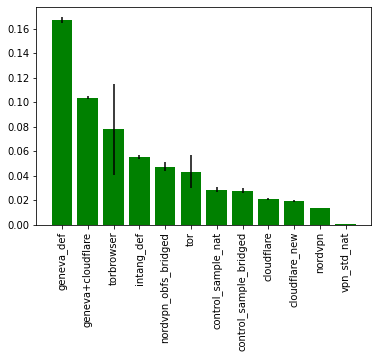

In [63]:
latencies_data_sorted = latencies_data.sort_values('ack_rtt_avg', ascending=False)
bar = plt.bar(latencies_data_sorted.index, latencies_data_sorted.ack_rtt_avg, color='green', yerr=[packet_dfs[policy].ack_rtt.std()/np.sqrt(packet_dfs[policy].ack_rtt.count())*1.96 for policy in latencies_data_sorted.index])
# figure(figsize=(10, 6), dpi=80)
# plt.savefig("test")
# lt.setp(bar.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xticks(rotation=90)
# plt.savefig("latencies_egypt_FINAL_ack_rtt_avg")

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

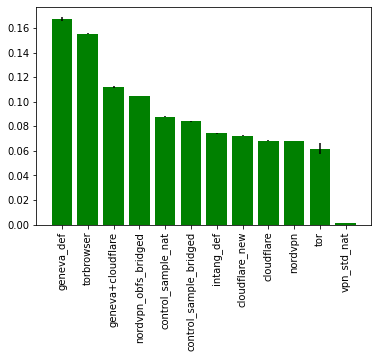

In [64]:
latencies_data_sorted = latencies_data.sort_values('irtt_avg', ascending=False)
bar = plt.bar(latencies_data_sorted.index, latencies_data_sorted.irtt_avg, color='green', yerr=[packet_dfs[policy].initial_rtt.std()/np.sqrt(packet_dfs[policy].initial_rtt.count())*1.96 for policy in latencies_data_sorted.index])
# figure(figsize=(10, 6), dpi=80)
# plt.savefig("test")
# lt.setp(bar.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xticks(rotation=90)
# plt.savefig("latencies_egypt_FINAL_irtt_avg")

In [71]:
max_len = max([len(list(packet_dfs[policy].ack_rtt)) for policy in policies])
ack_rtt_data = pd.DataFrame.from_dict({
    policy: list(packet_dfs[policy].ack_rtt) + ([None] * (max_len - len(packet_dfs[policy].ack_rtt))) for policy in [x for x in policies if x != 'vpn_std_nat']
})
ack_rtt_data

,control_sample_nat,control_sample_bridged,geneva_def,intang_def,nordvpn_obfs_bridged,tor,torbrowser,cloudflare,geneva+cloudflare,cloudflare_new,nordvpn
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.205003,0.205804,0.102664,0.148605,NaN,0.199725,NaN,NaN,NaN
2,NaN,0.268542,0.009925,0.000059,0.000100,NaN,NaN,0.000074,NaN,NaN,NaN
3,0.225137,0.000040,NaN,NaN,NaN,0.148136,NaN,NaN,NaN,NaN,0.065030
4,0.000104,NaN,NaN,0.205612,0.103517,NaN,NaN,0.200682,0.205797,0.195978,0.000055
...,...,...,...,...,...,...,...,...,...,...,...
493974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
493975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
493976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
493977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
ack_rtt_data.control_sample_bridged.describe()

count    19525.000000
mean         0.027767
std          0.139555
min          0.000004
25%          0.000021
50%          0.000145
75%          0.043718
max         11.317804
Name: control_sample_bridged, dtype: float64

In [73]:
ack_rtt_data.count()

control_sample_nat         24766
control_sample_bridged     19525
geneva_def                 27087
intang_def                 63818
nordvpn_obfs_bridged       29958
tor                           78
torbrowser                    18
cloudflare                 19794
geneva+cloudflare          21275
cloudflare_new             15420
nordvpn                   210430
dtype: int64

<AxesSubplot:ylabel='Density'>

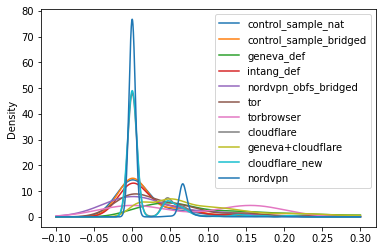

In [74]:
ack_rtt_data.plot.kde(ind=np.arange(-0.1,0.3,0.0001))

In [36]:
irtt_data = pd.DataFrame.from_dict({
    policy: list(packet_dfs[policy].initial_rtt) + ([None] * (max_len - len(packet_dfs[policy].initial_rtt))) for policy in [x for x in policies if x != 'torbrowser']
})
irtt_data

,control_sample_nat,control_sample_bridged,geneva_def,intang_def,nordvpn_obfs_bridged,tor,cloudflare_new,geneva+cloudflare
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.214927,0.205863,0.102764,NaN,NaN,NaN
2,NaN,0.268582,0.214927,0.205863,0.102764,NaN,NaN,NaN
3,0.225241,0.268582,0.214927,0.205863,0.102764,NaN,NaN,NaN
4,0.225241,0.268582,0.214927,0.205863,0.102764,NaN,0.196116,0.209632
...,...,...,...,...,...,...,...,...
189448,NaN,NaN,NaN,0.567478,NaN,NaN,NaN,NaN
189449,NaN,NaN,NaN,0.364666,NaN,NaN,NaN,NaN
189450,NaN,NaN,NaN,0.030629,NaN,NaN,NaN,NaN
189451,NaN,NaN,NaN,0.073630,NaN,NaN,NaN,NaN


<AxesSubplot:ylabel='Density'>

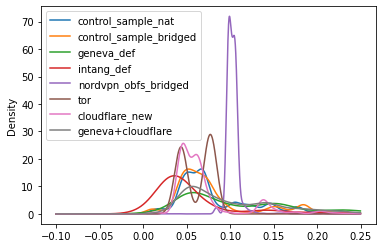

In [37]:
irtt_data.plot.kde(ind=np.arange(-0.1,0.25,0.00025))